## lab4

### 实验目标

在 lab 3 中，我们实现了 GraphSAGE（Hamilton 等人，2017）层。在这个 lab4 中，我们将实现一个更强大的层：GAT（Veličković等人，2018）。然后，我们将在 CORA 数据集上运行我们的模型。

### 实验说明

1. 需要大家完成的任务是加粗且带有得分的题目，如 `问题 i：XXXXXXX（15分）`
2. 做完实验后，请举手通知助教检查实验代码以及问题的输出结果，以便给同学们进行打分
3. 如果大家有疑问尽量在实验课的前60分钟提出，后30分钟主要用于检查同学们的实验结果，可能时间没那么充裕
4. 本次实验没有评分的实验任务，所有任务都会提供参考答案。同学们只需要按照参考答案的实现或者自行思考实现，将控制台输出给助教展示供助教打分即可。

### 实验过程

（1）安装实验所需的依赖包

In [ ]:
# 如果大家电脑里面有支持CUDA的GPU
# pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# pip install torch-geometric
# pip install -q git+https://github.com/snap-stanford/deepsnap.git

# 如果大家想用CPU来跑
# 请参考文章：https://blog.csdn.net/dream__1/article/details/122433061

# 验证是否安装成功，print(torch_geometric.__version__)

（2）GNN Stack Module

以下是通用 GNN 堆栈的实现，我们可以插入任何 GNN 层，例如 GraphSage、GAT 等。该模块已提供。在本次实验中实现的 GAT 层将作为 GNNStack 模块的组件运行。

In [2]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import softmax

import numpy as np
import matplotlib.pyplot as plt


class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers - 1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

（3）创建`Message Passing Layer`

> 本节中我们需要了解`Pytorch` 消息传递层的实现细节，从而构建自己的图神经网络模型。为此，我们将使用并实现 定义 `PyG `消息传递层所需的 3 个关键函数： `forward` ， `message` ，和 `aggregate` 。

**什么是消息传递？**

我们关注与单个中心节点 x 相关的单轮消息传递。在消息传递之前， x 与特征向量$x^{l-1}$相关联，消息传递的目的是更新这个特征向量$ x^l $。

 为此，需要执行以下步骤：

1. 每个相邻节点 v 通过边 (x,v) 传递其当前消息 $v^{l−1}$
2. 对于节点 x ，我们聚合相邻节点的所有消息（例如通过求和或平均值）
3. 通过例如应用线性和非线性变换来转换聚合信息。

总的来说，消息传递过程被应用于我们的图中的每个节点 u ，u 通过作为上述步骤 1-3 中描述的中心节点 x 来更新其嵌入。

现在，我们将此过程扩展到单层消息传递，消息传递层的任务是更新图中每个节点的当前特征表示或嵌入，通过在图中传播和转换信息来实现。总的来说，消息传递层的一般范式是：1）预处理 -> 2）消息传递/传播 -> 3）后处理。

具体的`forward` 函数处理节点特征/嵌入的预处理和后处理，并通过调用 `propagate` 函数来启动消息传递。`propagate` 函数封装了消息传递过程！它通过调用三个重要的函数来实现：1) `message` ，2) `aggregate` ，和 3) `update` 。我们的实现与这个略有不同（我们不会显式地实现 `update` ，而是在 `forward` 函数中放置更新节点嵌入的逻辑）。更具体地说，在信息传递之后，我们可以进一步转换由 `propagate` 输出的节点嵌入。因此， `forward` 的输出正好是经过一个 `GNN` 层后的节点嵌入。

> 了解上述函数

In [ ]:
# def propagate(edge_index, x=(x_i, x_j), extra=(extra_i, extra_j), size=size):
    # edge_index 传递给 forward 函数并捕获图的边结构。
    # x = (x_i, x_j) 表示将要用于消息传递的节点特征。为了解释为什么传递元组 (x_i, x_j) ，我们首先看看我们的边是如何表示的。对于每条边 (i,j) ∈ E，我们可以区分 i 为源节点（x_central）和 j 为相邻节点（x_neighbor）。
    # 以上面的消息传递为例，对于中心节点 u ，我们将聚合并转换与节点 v 关联的所有消息，即 (u,v) ∈ E（即 v ∈ Nei_u  ）。因此我们可以看到，下标 _i 和 _j 允许我们具体区分与中心节点（即接收消息信息的节点）和相邻节点（即传递消息的节点）相关的特征。
    # 还有一种理解方式：根据视角的不同，节点 x 可以作为一个中心节点或一个邻近节点。实际上，在无向图中，我们存储了边的两个方向（即 (i,j) 和 (j,i)）。从中心节点的角度来看x_i，x 正在收集邻近信息以更新其嵌入。从邻近节点的角度来看x_j，x 正在沿着连接到不同中心节点的边传递其消息信息。
    # extra=(extra_i, extra_j) 代表我们可以与每个节点关联的除其当前特征嵌入之外的信息。实际上，我们可以包含我们想要的任何形式的额外参数 param=(param_i, param_j) 。再次强调，使用 _i 和 _j 进行索引使我们能够区分中心和邻近节点。

    # 函数 propagate 的输出是消息传递过程后的节点嵌入矩阵，形状为  [N,d]  。

In [ ]:
# def message(x_j, ...):
    # message 函数由 propagate 调用，并从相邻节点 j 到中心节点 i 为每条边 (i,j)  在 edge_index 中构建消息。此函数可以接受最初传递给 propagate 的任何参数。此外，我们还可以通过在变量名后附加 _i 或 _j 来再次区分中心节点和相邻节点，例如 x_i 和 x_j 。更具体地看变量，我们有：
    # x_j 代表所有相邻节点通过各自的边传递消息的特征嵌入矩阵（即所有节点 j 对于边  (i,j) ∈ E），因此其形状为  [|E|,d]

    # message 函数的输出是一个邻接节点嵌入矩阵，准备进行聚合，其形状为  [|E|,d]

In [ ]:
# def aggregate(self, inputs, index, dim_size = None):
    #  aggregate 函数用来聚合来自邻接节点的消息
    # inputs 代表从邻接节点传递的消息矩阵（即 message 函数的输出）
    # index 与 inputs 具有相同的形状，并告诉我们每个行消息 j 在 inputs 矩阵中对应的中心节点。因此， index 告诉我们为每个中心节点聚合哪些行消息。

    # aggregate 的输出形状为 [N,d]

**（4）问题1：实现 GAT （100分）**

注意力机制已成为许多基于序列的任务（如机器翻译和学习句子表示）中的最先进技术。基于注意力机制的优点之一是它们能够专注于输入中最相关的部分来做出决策。在这个问题中，我们将看到如何通过使用图注意力网络（GATs）（Veličković等人，2018）来利用注意力机制对图结构数据进行节点分类。

图注意力网络的基本构建模块是图注意力层，它是一种聚合函数的变体。设 N 为节点数， F 为每个节点的特征向量的维度。每个图注意力层的输入是一组节点特征：$\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$。每个图注意力层的输出是一组新的节点特征，可能具有新的维度$F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$,  $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$。

我们将描述如何对每个图注意力层执行此转换

首先，对每个节点应用由权重矩阵 $\mathbf{W} \in \mathbb{R}^{F' \times F}$ 参数化的共享线性转换。

接下来对节点进行自注意力计算。我们使用共享的注意力函数 a:
$$
\begin{equation}
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}
$$
然后计算节点 j 的特征对节点 i 重要性 attention 系数:
$$
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}
$$
自注意力机制的最一般形式允许每个节点关注所有其他节点，这会丢失所有结构信息。为了在注意力机制中利用图结构，我们使用掩码注意力。在掩码注意力中，我们只为节点 $j \in \mathcal{N}_i$  计算注意力系数 $e_{ij}$ ，其中 $\mathcal{N}_i$ 是图中节点 i 的某个邻域。

为了方便在不同节点间比较系数，我们使用 softmax 函数对 j 中的系数进行归一化：
$$
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}
$$
我们的注意力机制 a 将是一个单层前馈神经网络，由权重向量 $\overrightarrow{a_l} \in \mathbb{R}^{F'}$ 和  $\overrightarrow{a_r} \in \mathbb{R}^{F'}$ 参数化，随后接一个 Leaky ReLU 非线性（负输入斜率为 0.2）。令 $\cdot^T$ 表示转置， || 表示拼接。我们注意力机制计算出的系数可以表示为：
$$
\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}
$$

对于以下问题，我们记 `alpha_l` = $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...] \in \mathcal{R}^n$ 、 `alpha_r` = $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...] \in \mathcal{R}^n$ 。

在 GAT 的每一层中，在计算完该层的注意力系数后，可以通过对邻居消息进行加权求和来计算聚合函数，其中权重由 $\alpha_{ij}$ 指定。

现在，我们使用归一化的注意力系数来计算与之对应的特征线性组合。这些聚合特征将作为每个节点的最终输出特征。

$$
\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}
$$

> Multi-Head Attention 多头注意力

为了稳定自注意力机制的学习过程，我们使用多头注意力机制。为此，我们使用 K 个独立的注意力机制，或称为“头”，按照上述方程计算输出特征。然后，我们将这些输出特征表示连接起来：
$$
\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}
$$
其中 $||$ 表示拼接, $\alpha_{ij}^{(k)}$ 是由第 $k$ 个 注意力机制  $(a^k)$ 计算出的归一化注意力系数， $\mathbf{W}^{(k)}$ 是相应的输入线性变换的权重矩阵。请注意，对于此设置 $\mathbf{h'} \in \mathbb{R}^{KF'}$.

In [3]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        ############################################################################
        # TODO: code here!
        # 定义self.lin_l（线性层）。
        # 我们使用的是多头注意力，所以请注意线性层的维度。
        self.lin_l = nn.Linear(in_channels, heads * out_channels)

        ############################################################################

        self.lin_r = self.lin_l

        ############################################################################
        # TODO: code here!
        # (1) 初始化注意力参数(self.att_l, self.att_r)
        # (2) 注意多头注意力的场景
        # (3) 使用 nn.Parameter 代替 nn.Linear
        self.att_l = nn.Parameter(data = torch.zeros(heads,  out_channels))
        self.att_r = nn.Parameter(data = torch.zeros(heads,  out_channels))

        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):

        H, C = self.heads, self.out_channels

        ############################################################################
        # TODO: code here!
        # 执行消息传递以及任何前处理和后处理（更新规则）。
        # 1. 首先对节点嵌入应用线性变换，并将其分成多个头。我们对源节点和目标节点使用相同的表示法，但应用不同的线性权重（W_l 和 W_r）
        # 2. 计算中心节点（alpha_l）和邻居节点（alpha_r）的 alpha 向量。
        # 3. 调用 propagate 函数进行信息传递。
        # 3.1 记住将 alpha = (alpha_l, alpha_r) 作为参数传递。
        # 3.2 更多信息请参考：https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html。
        # 4. 将输出转换回 [N, H * C] 的形状。
        x_l = self.lin_l(x).reshape(-1, H, C)
        x_r = self.lin_r(x).reshape(-1, H, C)
        
        alpha_l = self.att_l * x_l
        alpha_r = self.att_r * x_r
        
        out = self.propagate(edge_index=edge_index, x = (x_l, x_r), alpha = (alpha_l, alpha_r), size=size).reshape(-1, H * C)


        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: code here!
        # 1. 使用 alpha_i 和 alpha_j 计算最终注意力权重，并应用 Leaky Relu 激活函数。
        # 2. 计算所有节点邻居节点的 softmax。使用 torch_geometric.utils.softmax 代替 Pytorch 中的 softmax。
        # 3. 对注意力权重 (alpha) 应用 dropout。
        # 4. 将嵌入和注意力权重相乘。作为正确性检查，输出的维度应为 [E, H, C] 。
        # ptr （LongTensor类型，可选参数）： 如果给定，则根据 CSR 表示中的排序输入计算 softmax。你可以简单地将它传递给 softmax。
        alpha = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)

        if ptr:
            att_weight = softmax(alpha, ptr)
        else:
            att_weight = softmax(alpha, index)
        att_weight = F.dropout(att_weight, p=self.dropout)

        out = att_weight * x_j


        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # TODO: code here!
        out = torch_scatter.scatter(inputs, index=index, dim=self.node_dim, dim_size=dim_size, reduce='sum')
        ############################################################################

        return out

（5）Building Optimizers 构建优化器

这个函数已经实现。为了方便助教评分，请使用默认的 Adam 优化器，但同学们也可以自由地尝试其他类型的优化器看能否取得更好的效果。

In [4]:
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

（6）训练和测试

In [5]:
def train(dataset, args):
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes,
                     args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            test_accs.append(test_acc)
        else:
            test_accs.append(test_accs[-1])
    return test_accs, losses


def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]

        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total


class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

（7）输出结果

我们将使用 CORA 数据集进行节点级别的分类，为了便于助教评分，请不要修改默认参数。但是，同学们也可以自由地尝试不同的配置

Node task. test set size: 140


c:\Users\DreamingLri\.conda\envs\graph_ml\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Maximum accuracy: 0.76
Minimum loss: 0.029366683214902878


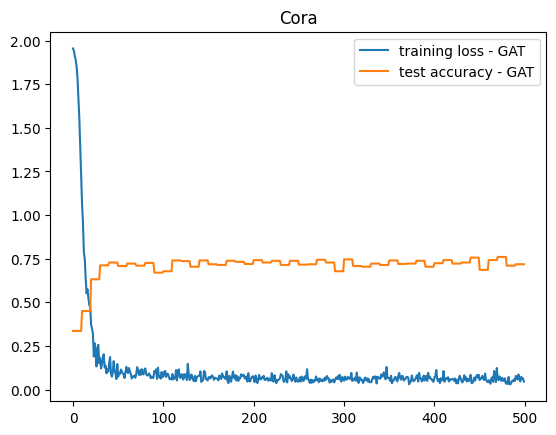

In [6]:
for args in [
    {'model_type': 'GAT', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32,
     'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3,
     'lr': 0.01},
]:
    args = objectview(args)
    for model in ['GAT']:
        args.model_type = model

        # Match the dimension.
        if model == 'GAT':
            args.heads = 2
        else:
            args.heads = 1

        if args.dataset == 'cora':
            dataset = Planetoid(root='./dataset/data1', name='Cora')
        else:
            raise NotImplementedError("Unknown dataset")
        test_accs, losses = train(dataset, args)

        print("Maximum accuracy: {0}".format(max(test_accs)))
        print("Minimum loss: {0}".format(min(losses)))

        plt.title(dataset.name)
        plt.plot(losses, label="training loss" + " - " + args.model_type)
        plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
    plt.legend()
    plt.show()